In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import torch
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler


## Viz raw dataset

In [ ]:
import os

folder_path = '/content/drive/MyDrive/CS240/NSL-KDD'

train_file = 'KDDTrain+.txt'
train_path = os.path.join(folder_path, train_file)
data_train = pd.read_csv(train_path)
# data_train.head()

test_file = 'KDDTest+.txt'
test_path = os.path.join(folder_path, test_file)
data_test = pd.read_csv(test_path)

print("Length of training set: ", len(data_train))
print("Length of testing set: ", len(data_test))

Length of training set:  125972
Length of testing set:  22543


## Updating dataset with Column labels



In [ ]:
# Define the column labels for the NSL-KDD dataset
column_labels = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
                 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
                 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
                 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
                 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
                 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
                 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                 'dst_host_srv_rerror_rate', 'attack', 'level']
data_train.columns = column_labels
data_test.columns = column_labels

In [ ]:
is_attack = data_train.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = data_test.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
data_train['attack'] = is_attack
data_test['attack'] = test_attack

In [ ]:
df = pd.concat([data_train, data_test])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,0,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,1,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,0,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,1,21


In [ ]:
df_cat = df.select_dtypes(exclude=[np.number])
print(df_cat.columns)
for feature in df_cat.columns:
    df[feature] = LabelEncoder().fit_transform(df[feature])

Index(['protocol_type', 'service', 'flag'], dtype='object')


## Types of Attacks

## FEATURE EXTRACTION

In [ ]:
# Define the columns to keep
columns_to_keep = ['duration', 'protocol_type', 'src_bytes', 'logged_in', 'is_host_login',
                   'srv_serror_rate', 'rerror_rate', 'same_srv_rate', 'srv_diff_host_rate', 'attack']

df = df[columns_to_keep]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148515 entries, 0 to 22542
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   duration            148515 non-null  int64  
 1   protocol_type       148515 non-null  int64  
 2   src_bytes           148515 non-null  int64  
 3   logged_in           148515 non-null  int64  
 4   is_host_login       148515 non-null  int64  
 5   srv_serror_rate     148515 non-null  float64
 6   rerror_rate         148515 non-null  float64
 7   same_srv_rate       148515 non-null  float64
 8   srv_diff_host_rate  148515 non-null  float64
 9   attack              148515 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 12.5 MB


## PRE-PROCESSING

DATA SPLIT


In [ ]:
# X_train = train_data.drop(columns=['attack_cat'])  # Features
# y_train = train_data['attack_cat']  # Target

X = df.drop(columns=['attack'])
feature_list = list(X.columns)
X = np.array(X)
y = df['attack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

ENCODING AND SCALING

## MLP MODEL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.optim.lr_scheduler as lr_scheduler

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 5)
        self.fc5 = nn.Linear(5, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
# Define input dimension
input_dim = X_train.shape[1]
batch_size = 64
epochs = 50


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to GPU
model = NeuralNetwork(input_dim).to(device)

# Convert your data to PyTorch tensors and move to GPU
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Define your dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Train your model
total_batches = len(train_loader)
# Define early stopping parameters
early_stopping_rounds = 5
best_val_loss = float('inf')
best_epoch = 0
early_stopping_counter = 0

In [ ]:
# Train your model
print("Using device: ", device)
for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    with tqdm(total=total_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i+1)})
            pbar.update(1)

        # Calculate validation loss
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            val_loss = criterion(test_outputs, y_test_tensor)
            print(f"Train loss: {running_loss/(i+1)} Validation loss : {val_loss}")
            scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_rounds:
                print(f'Early stopping triggered! No improvement in validation loss for {early_stopping_rounds} consecutive epochs.')
                break

print('Training completed!')

# Evaluate your model
with torch.no_grad():
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    train_acc = (train_outputs.argmax(dim=1) == y_train_tensor).float().mean()

    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_acc = (test_outputs.argmax(dim=1) == y_test_tensor).float().mean()

print(f'Train: Loss: {train_loss.item()}, Accuracy: {train_acc.item()}')
print(f'Validation: Loss: {test_loss.item()}, Accuracy: {test_acc.item()}')
print(f'Best Validation Loss: {best_val_loss.item()} at Epoch {best_epoch+1}')


Using device:  cuda


Epoch 1/50: 100%|██████████| 1857/1857 [00:11<00:00, 168.26batch/s, loss=0.701]


Train loss: 0.7010690464117094 Validation loss : 0.2640013098716736


Epoch 2/50: 100%|██████████| 1857/1857 [00:09<00:00, 193.80batch/s, loss=0.253]


Train loss: 0.2527214691652748 Validation loss : 0.2589337229728699


Epoch 3/50: 100%|██████████| 1857/1857 [00:09<00:00, 195.53batch/s, loss=0.248]


Train loss: 0.2480762061022531 Validation loss : 0.2583111524581909


Epoch 4/50: 100%|██████████| 1857/1857 [00:10<00:00, 182.81batch/s, loss=0.248]


Train loss: 0.24786933826851343 Validation loss : 0.2536240220069885


Epoch 5/50: 100%|██████████| 1857/1857 [00:09<00:00, 193.10batch/s, loss=0.247]


Train loss: 0.2469159242650419 Validation loss : 0.25232797861099243


Epoch 6/50: 100%|██████████| 1857/1857 [00:10<00:00, 174.79batch/s, loss=0.247]


Train loss: 0.24670673352723874 Validation loss : 0.25345557928085327


Epoch 7/50: 100%|██████████| 1857/1857 [00:10<00:00, 177.42batch/s, loss=0.246]


Train loss: 0.24606982434813413 Validation loss : 0.25103291869163513


Epoch 8/50: 100%|██████████| 1857/1857 [00:09<00:00, 188.24batch/s, loss=0.248]


Train loss: 0.2476179216159372 Validation loss : 0.25146350264549255


Epoch 9/50: 100%|██████████| 1857/1857 [00:10<00:00, 184.12batch/s, loss=0.245]


Train loss: 0.24471127455296796 Validation loss : 0.25145837664604187


Epoch 10/50: 100%|██████████| 1857/1857 [00:10<00:00, 181.04batch/s, loss=0.251]


Train loss: 0.251323912370956 Validation loss : 0.2578616738319397


Epoch 11/50: 100%|██████████| 1857/1857 [00:10<00:00, 174.33batch/s, loss=0.244]


Train loss: 0.24420101602808017 Validation loss : 0.2515175938606262


Epoch 12/50: 100%|██████████| 1857/1857 [00:09<00:00, 191.97batch/s, loss=0.242]


Train loss: 0.24240301190546976 Validation loss : 0.25027039647102356


Epoch 13/50: 100%|██████████| 1857/1857 [00:10<00:00, 184.68batch/s, loss=0.242]


Train loss: 0.24213412393227532 Validation loss : 0.2503780424594879


Epoch 14/50: 100%|██████████| 1857/1857 [00:09<00:00, 194.83batch/s, loss=0.242]


Train loss: 0.24206955388677845 Validation loss : 0.24954985082149506


Epoch 15/50: 100%|██████████| 1857/1857 [00:09<00:00, 185.88batch/s, loss=0.242]


Train loss: 0.2417725398855692 Validation loss : 0.24872596561908722


Epoch 16/50: 100%|██████████| 1857/1857 [00:10<00:00, 179.23batch/s, loss=0.242]


Train loss: 0.24156160391044668 Validation loss : 0.2484598606824875


Epoch 17/50: 100%|██████████| 1857/1857 [00:09<00:00, 192.14batch/s, loss=0.242]


Train loss: 0.2415045389226514 Validation loss : 0.2482726275920868


Epoch 18/50: 100%|██████████| 1857/1857 [00:10<00:00, 184.41batch/s, loss=0.241]


Train loss: 0.2410695147216641 Validation loss : 0.24878695607185364


Epoch 19/50: 100%|██████████| 1857/1857 [00:10<00:00, 180.91batch/s, loss=0.241]


Train loss: 0.24106278390045377 Validation loss : 0.24796222150325775


Epoch 20/50: 100%|██████████| 1857/1857 [00:09<00:00, 198.50batch/s, loss=0.241]


Train loss: 0.24088354931124192 Validation loss : 0.24837160110473633


Epoch 21/50: 100%|██████████| 1857/1857 [00:10<00:00, 184.63batch/s, loss=0.241]


Train loss: 0.24053645280415997 Validation loss : 0.24729561805725098


Epoch 22/50: 100%|██████████| 1857/1857 [00:09<00:00, 189.70batch/s, loss=0.24]


Train loss: 0.240497080373488 Validation loss : 0.24771682918071747


Epoch 23/50: 100%|██████████| 1857/1857 [00:09<00:00, 199.07batch/s, loss=0.24]


Train loss: 0.24022405424471754 Validation loss : 0.2487277090549469


Epoch 24/50: 100%|██████████| 1857/1857 [00:10<00:00, 182.22batch/s, loss=0.24]


Train loss: 0.24028641401549855 Validation loss : 0.24729327857494354


Epoch 25/50: 100%|██████████| 1857/1857 [00:09<00:00, 192.45batch/s, loss=0.24]


Train loss: 0.24018597959926452 Validation loss : 0.2468978315591812


Epoch 26/50: 100%|██████████| 1857/1857 [00:09<00:00, 194.18batch/s, loss=0.24]


Train loss: 0.2401135566699036 Validation loss : 0.24980378150939941


Epoch 27/50: 100%|██████████| 1857/1857 [00:10<00:00, 183.66batch/s, loss=0.24]


Train loss: 0.24009633528476898 Validation loss : 0.24739386141300201


Epoch 28/50: 100%|██████████| 1857/1857 [00:09<00:00, 195.89batch/s, loss=0.24]


Train loss: 0.24001215262700618 Validation loss : 0.2470816820859909


Epoch 29/50: 100%|██████████| 1857/1857 [00:09<00:00, 187.11batch/s, loss=0.24]


Train loss: 0.23993178522821132 Validation loss : 0.24785971641540527


Epoch 30/50: 100%|██████████| 1857/1857 [00:09<00:00, 186.16batch/s, loss=0.239]


Train loss: 0.2392547762740602 Validation loss : 0.24711667001247406
Early stopping triggered! No improvement in validation loss for 5 consecutive epochs.
Training completed!
Train: Loss: 0.2387639284133911, Accuracy: 0.9162037968635559
Validation: Loss: 0.24711667001247406, Accuracy: 0.9125341176986694
Best Validation Loss: 0.2468978315591812 at Epoch 25


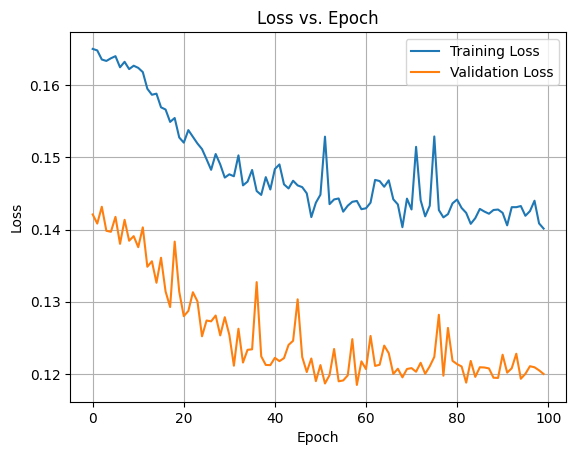

In [ ]:
# Extract loss and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss vs. epoch
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

## SELF REF

KDD -> UNSW (Attack cats)

1. 'normal'          -> 'Normal'
2. 'neptune'         -> 'DoS'
3. 'warezclient'     -> 'Backdoor'
4. 'ipsweep'         -> 'Reconnaissance'
5. 'portsweep'       -> 'Reconnaissance'
6. 'teardrop'        -> 'DoS'
7. 'nmap'            -> 'Reconnaissance'
8. 'satan'           -> 'Reconnaissance'
9. 'smurf'           -> 'DoS'
10. 'pod'             -> 'DoS'
11. 'back'            -> 'Backdoor'
12. 'guess_passwd'    -> 'Unauthorized Access'
13. 'ftp_write'       -> 'Unauthorized Access'
14. 'multihop'        -> 'Unauthorized Access'
15. 'rootkit'         -> 'Backdoor'
16. 'buffer_overflow' -> 'Exploits'
17. 'imap'            -> 'Unauthorized Access'
18. 'warezmaster'     -> 'Backdoor'
19. 'phf'             -> 'Unauthorized Access'
20. 'land'            -> 'DoS'
21. 'loadmodule'      -> 'Exploits'
22. 'spy'             -> 'Unauthorized Access'
23. 'perl'            -> 'Exploits'
